# Tópicos de Ciência de Dados - Classificação de Atividades Humanas
Gonçalo Coelho 2018265127 <br>
Pedro Sá 2021206293

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import copy
import matplotlib.cm as cm
import scipy.spatial as spatial
import scipy.stats as stats
from scipy.fft import fft

In [3]:
features = [
    'device_id',
    'acc_x','acc_y','acc_z',
    'gyro_x','gyro_y','gyro_z',
    'mag_x','mag_y','mag_z',
    'timestamp',
    'label',
]

activities = [
    'stand',
    'sit',
    'sit and talk',
    'walk',
    'walk and talk',
    'climb stairs',
    'climb stairs and talk','stand -> sit',
    'sit -> stand',
    'stand -> sit and talk',
    'sit and talk -> stand',
    'stand -> walk',
    'walk -> stand',
    'stand -> climb stairs (and talk)',
    'climb stairs -> walk',
    'climb stairs and talk -> walk and talk'
]

In [4]:
def read_data(user_id):
    '''read_data -> read data from csv file
    ---
    user_id -> id of the user to read the data from
    ---
    returns: data -> data from all 5 devices from individual
    '''
    fullpath = f'dataset/part{user_id}'
    devices = [0,0,0,0,0] # 5 devices

    for i in range (1,6):
        devices[i-1] = np.genfromtxt(f'{fullpath}/part{user_id}dev{i}.csv', delimiter=',')

    data = np.concatenate(devices,axis=0) # concatenate device data into a singular, individual dataset

    return data
read_data(0)

array([[ 1.0000e+00, -1.8650e+00,  9.3890e+00, ...,  1.0134e+00,
         5.0589e+02,  1.0000e+00],
       [ 1.0000e+00, -1.7963e+00,  9.3742e+00, ...,  1.0000e+00,
         5.2542e+02,  1.0000e+00],
       [ 1.0000e+00, -1.8696e+00,  9.3000e+00, ...,  1.0156e+00,
         5.4495e+02,  1.0000e+00],
       ...,
       [ 5.0000e+00, -4.9463e-01,  9.4428e+00, ...,  7.1739e-02,
         1.0380e+06,  1.0000e+00],
       [ 5.0000e+00, -4.7013e-01,  9.4553e+00, ...,  8.4783e-02,
         1.0381e+06,  1.0000e+00],
       [ 5.0000e+00, -4.9427e-01,  9.4431e+00, ...,  7.8261e-02,
         1.0381e+06,  1.0000e+00]])

In [452]:
# read data
user_data = [read_data(i) for i in range(0,15)]

# all data
all_data = np.concatenate(user_data)

In [5]:
# Helper functions
def iqr_outliers(array):
    '''
    Return an array of outliers from initial array \'array\'
    ---
    \'array\', array of values
    '''
    q3, q1 = np.percentile(array, [75, 25])
    iqr = q3 - q1

    return array[(array < (q1 - 1.5*iqr)) | ((q3 + 1.5*iqr) < array)]
    
def density(n0 = 0, nt = 1):
    '''
    Calculate density
    '''
    return n0*100/nt

## Exercise 3.1
The method below plots the transformed variables in relation to every activity

In [6]:
def plot_transform(data, dev = 0):
    '''
    Plots transfomed dataset into 3 boxplots (gyreleration, gyroscope and magnetometer) for all 16 activities
    ---
    data -> transformed dataset with collapsed x, y and z values into each transformed module (gyr, gyr and mag)
    dev  -> device to plot (between 1, 2, 3, 4 and 5). 0 considers data from all devices
    '''
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    modules = ['|Acceleration|', '|Gyro|', '|Magnetometer|']
    fin = [0]*3
    for ax, i in zip(axs.flatten(), range(0,3)):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

        ax.yaxis.set_ticks_position('none')
        ax.grid(color='grey',axis='y',linestyle='-', linewidth=0.10, alpha=0.5)
        ax.tick_params('x', labelrotation=90, labelsize=9)
        ax.set(
            title = f'Distribution of {modules[i]} by activity',
            xlabel = 'Activities',
            ylabel = f'{modules[i]}'
        )

        plt_data = [0] * 16
        res = [0] * 16
        for j in range(0, 16): # each activity
            if dev == 0:
                plt_data[j] = np.concatenate([data[x][data[x][:,5]==j+1][:,i+1] for x in range(0,15)])
            else:
                plt_data[j] = np.concatenate([data[x][(data[x][:,5]==j+1) & (data[x][:,0] == dev)][:,i+1] for x in range(0,15)])

            # get outliers
            outliers = iqr_outliers(plt_data[j])
            res[j] = density(len(outliers),len(plt_data[j]))
            #print(f'{np.around(density(outliers.shape[0],plt_data[j].shape[0]),2)}')
            
        ax.boxplot(plt_data, labels=activities)
        fin[i] = res

    plt.show()
    return fin

# Exercício 3.2

In [7]:
data_transformed = [np.column_stack((
    user_data[x][:,0],
    np.sqrt(np.sum(user_data[x][:,1:4]**2, axis=1).astype(float)), # acceleration module
    np.sqrt(np.sum(user_data[x][:,4:7]**2, axis=1).astype(float)), # gyroscope module
    np.sqrt(np.sum(user_data[x][:,7:10]**2, axis=1).astype(float)), # magnetometer module
    user_data[x][:,10:]
    )) for x in range(0,15)]

data_mod = np.concatenate(data_transformed)

NameError: name 'user_data' is not defined

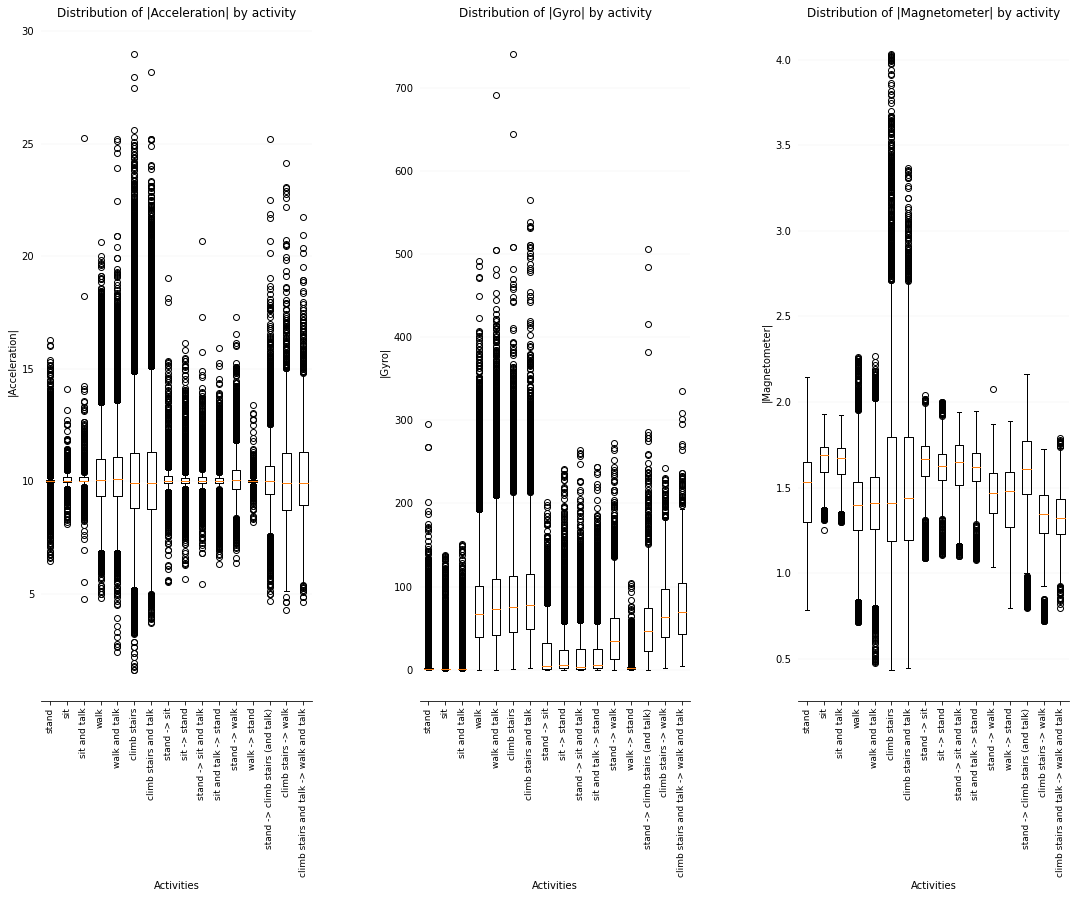

In [510]:
# plot transformed dataset, only for right wrist data (dev = 2)
iqr_outliers_v = plot_transform(data_transformed, dev = 2)

From the image above, we can observe a greater outlier density on the acceleration module. This can be attributed to sudden peaks in data measurements when switching from stances. The magnetometer apears to have the smallest outlier density.

## Exercise 3.3
This method performes outlier identification through the z-score test

In [513]:
def z_score(array, k):
    z = array - np.mean(array)
    mask = np.where(np.abs(z/array.std()) > k)
    return array[mask]

def zscore(array, k=3):
    ''' z-score - Peforms z-score outlier detectino on array "array"
    
    Returns:
    . data array without outliers
    . outliers
    . indices of outliers
    '''

    z = np.abs((array - array.mean())/array.std())
    return array[z < k], array[z > k], np.argwhere(z > k).squeeze()

## Exercise 3.4

In [514]:
def plot_outliers(dev = 1, k = 3 ) -> None:
    """
    [summary]

    Args:
        dev (int, optional): [description]. Defaults to 0.
        k (int, optional): [description]. Defaults to 3.
    
    """
    
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    modules = ['|Acceleration|', '|Gyro|', '|Magnitude|']
    fin = [0]*3
    for ax, i in zip(axs.flatten(), range(0,3)):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

        ax.yaxis.set_ticks_position('none')
        ax.grid(color='grey',axis='y',linestyle='-', linewidth=0.10, alpha=0.5)
        ax.tick_params('x', labelrotation=90, labelsize=9)
        ax.set(
            title = f'Distribution of {modules[i]} by activity',
            xlabel = 'Activities',
            ylabel = f'{modules[i]}'
        )
        
        # establish limits for slicing data for module calculation
        lim_inf = 1 if i == 0 else 4 if i == 1 else 7
        lim_sup = 4 if i == 0 else 7 if i == 1 else 10
        if dev > 0:
            filtered_data = [user_data[x][user_data[x][:,0]==dev] for x in range(0,15)]

        plt_data = [0] * 16
        res = [0] *16
        for act in range(0, 16):
            # module vector
            vector_module = np.concatenate([filtered_data[x][filtered_data[x][:,11]==act+1][:,lim_inf:lim_sup]**2 for x in range(0,15)], axis=0)

            plt_data[act] = np.sqrt(np.sum(vector_module, axis=1).astype(float))
            #zscore = stats.zscore(plt_data[act])
            zscore = z_score(plt_data[act],k)
            res[act] = density(len(zscore), len(plt_data[act]))
            normal, = ax.plot(np.zeros_like(plt_data[act])+act,plt_data[act],'bx')
            out, = ax.plot(np.zeros_like(zscore)+act,zscore,'rx')

        fin[i] = res 

        ax.legend([normal, out], ['Normal','Outlier'])

    return fin


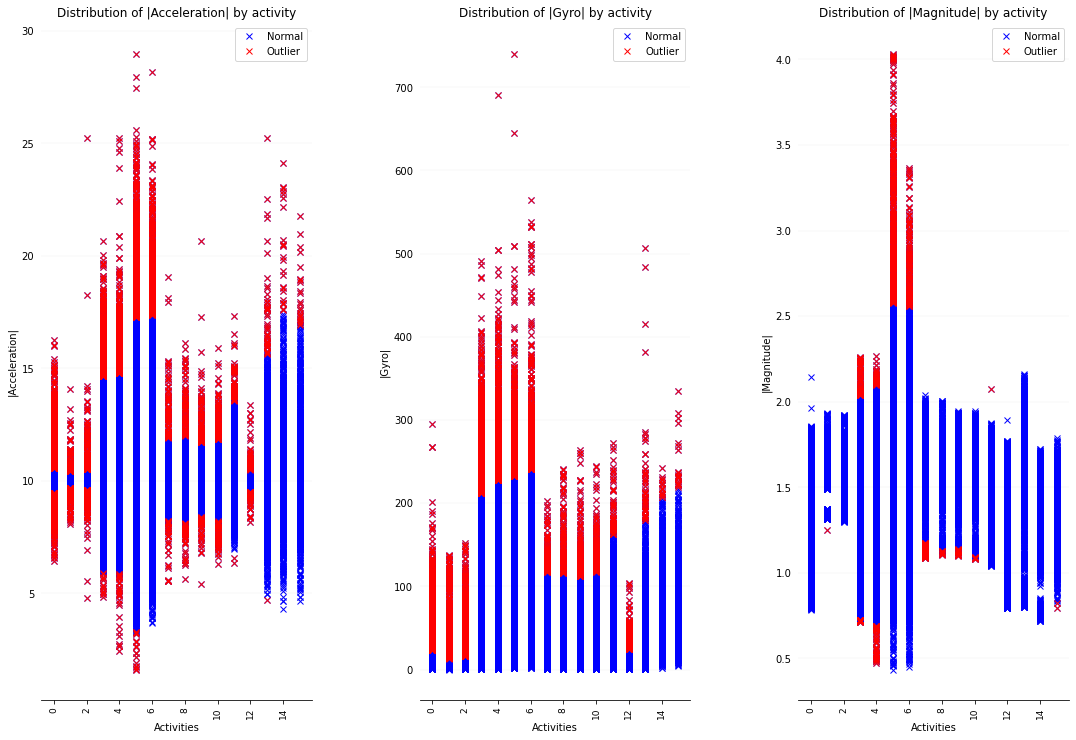

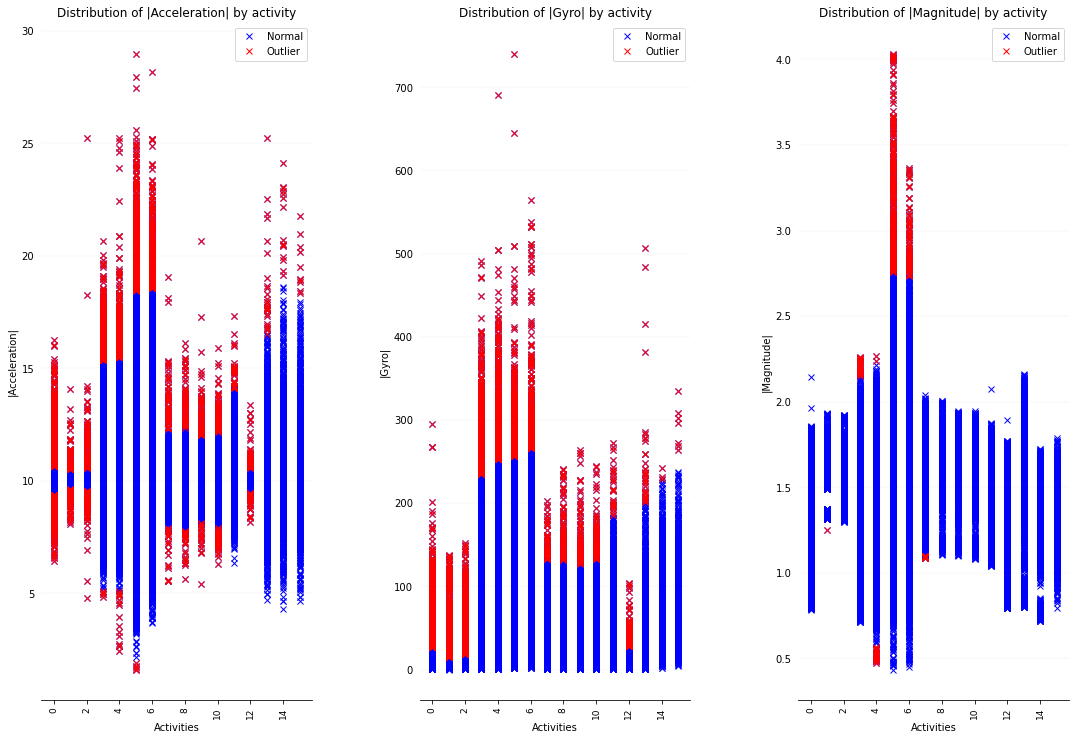

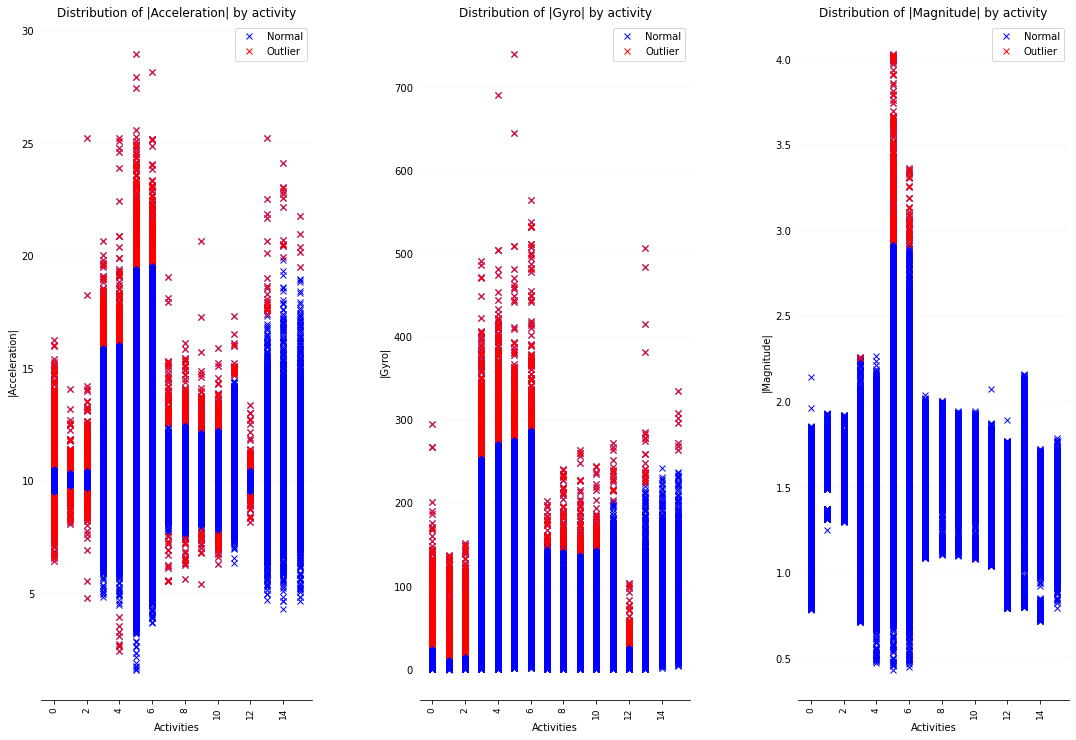

In [515]:
z_score_3 = plot_outliers(2,3)
z_score_3_5 = plot_outliers(2,3.5)
z_score_4 = plot_outliers(2,4)

Thus, we are able to say that for greater z-score's parameter *k*, the outlier density decreases

## Exercise 3.5

In [516]:
import pandas as pd
dicti = {"ACT": activities}
z_string = ["Z-SCORE 3 ","Z-SCORE 3.5 ","Z-SCORE 4 "]
tp_of = ["acc","gyr","mag"]
for i in range(0,3):
    
    dicti[z_string[0]+tp_of[i]] = z_score_3[i]
    dicti[z_string[1]+tp_of[i]] = z_score_3_5[i]
    dicti[z_string[2]+tp_of[i]] = z_score_4[i]
    dicti["IQR "+tp_of[i]] = iqr_outliers_v[i]

df = pd.DataFrame.from_dict(dicti)

In [517]:
# show dataframe
df

,ACT,Z-SCORE 3 acc,Z-SCORE 3.5 acc,Z-SCORE 4 acc,IQR acc,Z-SCORE 3 gyr,Z-SCORE 3.5 gyr,Z-SCORE 4 gyr,IQR gyr,Z-SCORE 3 mag,Z-SCORE 3.5 mag,Z-SCORE 4 mag,IQR mag
0,stand,0.841135,0.711291,0.618817,4.195538,1.487187,1.268669,1.104622,9.484932,0.000000,0.000000,0.000000,0.000000
1,sit,0.236995,0.206031,0.184594,0.215558,0.466845,0.423971,0.384670,6.646580,0.001191,0.001191,0.000000,6.672780
2,sit and talk,0.363515,0.301903,0.266167,0.513851,0.638308,0.565605,0.508922,9.117459,0.000000,0.000000,0.000000,4.766364
3,walk,1.069790,0.486658,0.202238,3.530950,0.910429,0.500236,0.300856,1.620764,0.082896,0.029300,0.002144,1.450684
4,walk and talk,1.069075,0.505739,0.212129,3.477656,0.867482,0.485369,0.277454,1.428009,0.064622,0.019668,0.000000,1.338803
5,climb stairs,1.301492,0.641234,0.322295,5.165680,0.906456,0.476729,0.224935,1.498450,0.493515,0.360344,0.223816,0.390559
6,climb stairs and talk,1.358727,0.666804,0.347103,4.514626,1.096116,0.607431,0.367655,2.073485,0.365372,0.203238,0.095910,0.221507
7,stand -> sit,1.832933,1.367188,1.141827,15.444712,1.832933,0.841346,0.405649,7.466947,2.524038,0.240385,0.000000,3.485577
8,sit -> stand,2.539062,1.882102,1.367188,19.797585,2.183949,1.491477,1.065341,10.777699,0.177557,0.000000,0.000000,7.350852
9,stand -> sit and talk,2.223558,1.487380,1.021635,15.324519,2.118389,1.216947,0.751202,10.336538,0.375601,0.000000,0.000000,0.841346


For most cases we can verify that there exists a high outlier density when using the z-score test. Between the several z-score tests performed, when *z=3*, the outlier density is the the larger. It can be, therefore, concluded thatn for most cases, the z-score test outputs a smaller quantity of outliers.

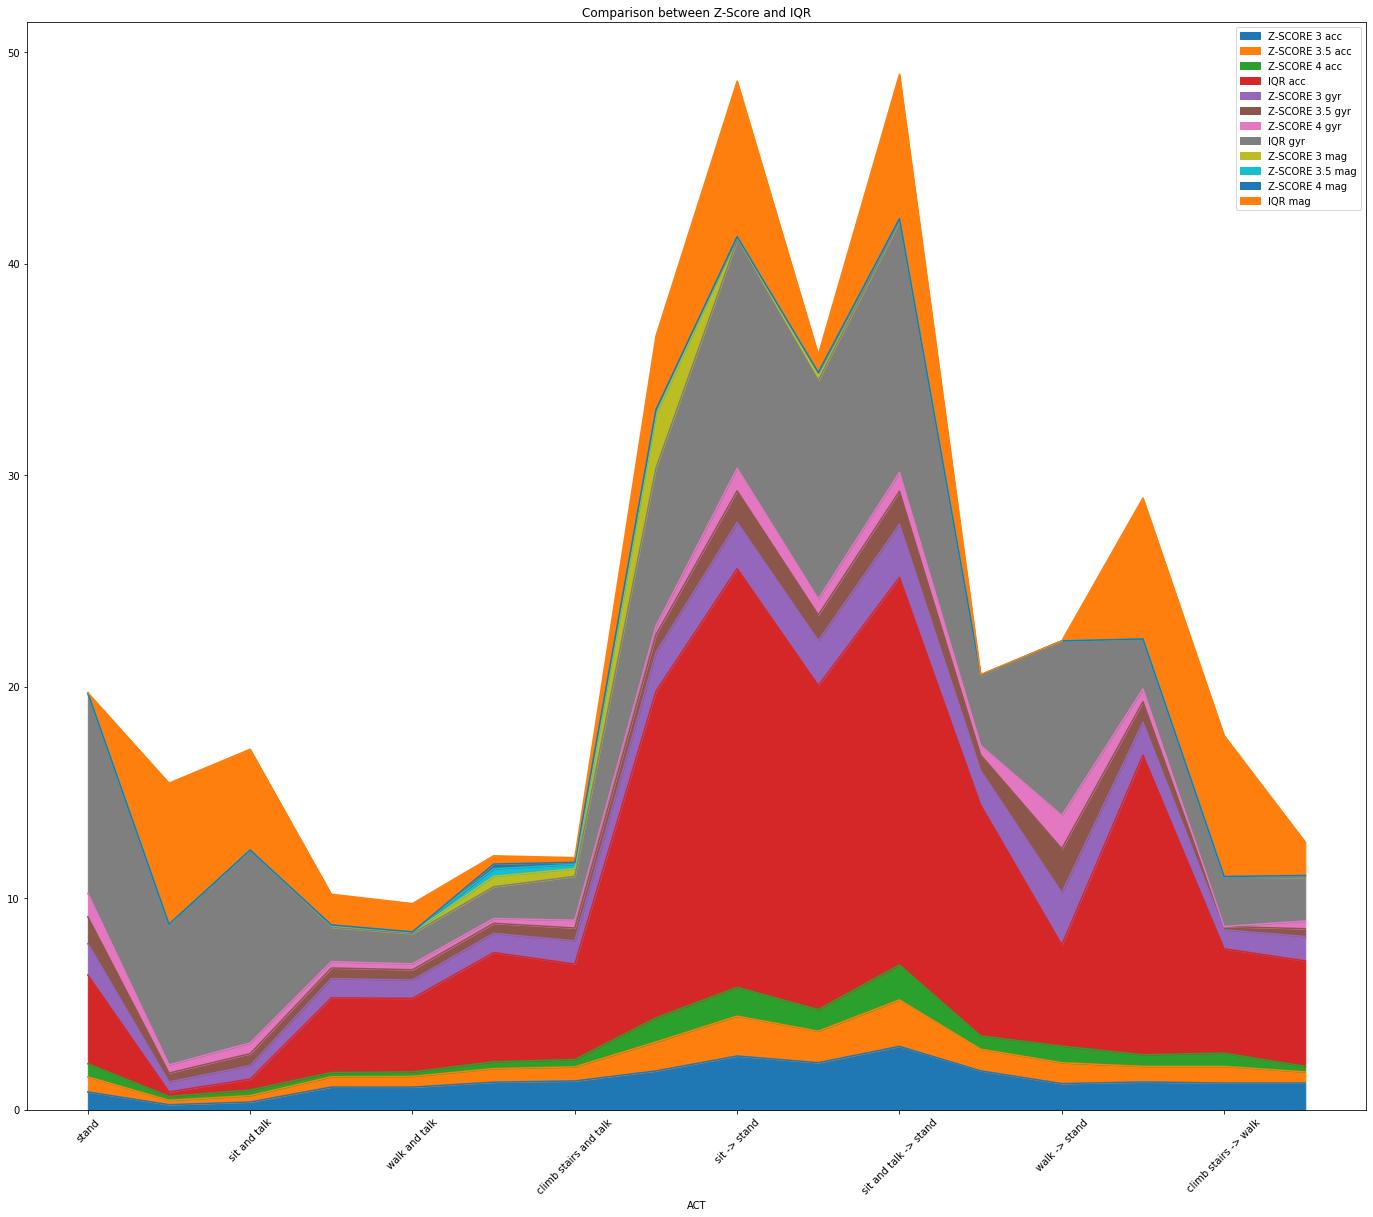

In [518]:
df.plot.area(figsize=(24,20), x="ACT")
plt.title("Comparison between Z-Score and IQR")
plt.xticks(rotation=45)
plt.show()

## Exercise 3.6
K-means implementation using eucliden distance. A stopping criteria of 0.0001 was additionally imposed as default, as this is a long process, further aggravated when dealing with large k values (when k=7, it usually takes +1h to compute). This way, as the clusters changes are minute, it's more worthy to stop as it be can assumed that it will slow down beyond that point.

As mentioned in <https://www.youtube.com/watch?v=IEBsrUQ4eMc>, a strategy for achieving the best k for the clustering was used, thus facilitating the number of tests to run.


In [520]:
class Kmeans:
    """
    It will use the KMeans algorithm to find the clusters that exist in
    the dataset 
    """
    def __init__(self,n_cluster=2,random_seed=0,stoppingCriteria = 0.0001, ax = None) -> None:
        """
        It will initialize the beggining of the KMeans algorithm
        n_cluster is the number of "classes" it will find
        random_seed is the state of the seed we want
        """
        self.n_cluster = n_cluster
        self.random_seed = random_seed
        self.stoppingCriteria = stoppingCriteria
        random.seed(random_seed)
        self.ax = ax
        if self.ax == None:
            fig = plt.figure(figsize=plt.figaspect(0.5))
            self.ax = plt.axes(projection='3d')

    def fit(self,data):
        """
        Computes the kmeans clustering
        """
        self.X = data
        self.s_training,self.s_features = self.X.shape
        init_centroids = self.X[self.initCentroids()]
        self.cluster(init_centroids)

    def initCentroids(self) -> np.array:
        """
        Creates an array of the centroids 
        """
        return np.random.choice(np.arange(self.s_training),self.n_cluster)

    def euclideanDistance(self,v1,v2):
        """Calculates the Euclidean distance between 2 arrays

        Args:
            v1 (array): first array
            v2 (array): the array to see the distance

        Returns:
           ndarray : the sqrt of all the sums between the 2 arrays
        """
        return np.sqrt(np.sum((np.array(v1) - np.array(v2))**2))
    
    def l1Distance(self,v1,v2):
        """Calculates the L1 or Manhatan distance between 2 arrays

        Args:
            v1 (array): first array
            v2 (array): the array to see the distance

        Returns:
           ndarray : the sqrt of all the sums between the 2 arrays
        """
        return np.sum(np.abs(np.array(v1)-np.array(v2)))

    def cluster(self,centroids):
        """It's the calculations to find the center of the centroids

        Args:
            centroids ([np.array]): centroids iniciados que vão ser atualizados ao longo do tempo.
                                    Aproveitando a mutabilidade em python para modificar o resultado
        """
        old = np.zeros(centroids.shape)
        

        while self.euclideanDistance(old,centroids) > self.stoppingCriteria:
            # Se a distancia dos velhos para os novos é 0 implica que não houve mudança, ou seja estão nas mesmas posições -> pontos nos mesmos centroides
            clusters = np.zeros(self.X.shape)

            for i in range(self.s_training):
                distances = [self.euclideanDistance(self.X[i,:],centroids[j]) for j in range(self.n_cluster)]
                clusters[i] = np.argmin(distances)
            
            old = copy.deepcopy(centroids)
            #deepcopy para não afetar as antigas coordenadas

            for i in range(self.n_cluster):
                #atualizar valores
                rows = np.where(clusters[:,0] == i )
                centroids[i] = np.mean(self.X[rows] ,axis=0)

        self.plot_centroids(centroids,clusters)
        self.centroids = centroids
        self.clusters = clusters


    def plot_centroids(self,centroids,clusters):
        """
        Creation of a scatter3D plot from the dataset given
        
        """
        
        x = np.arange(centroids.shape[0])
        ys = [i+x+(i*x)**2 for i in range(centroids.shape[0])]

        colors = cm.rainbow(np.linspace(0, 1, len(ys)))

        
        for i in range(self.n_cluster):
            rows = np.where(clusters[:,0] == i )
            points = self.X[rows]
            self.ax.scatter3D(points[:,0],points[:,1],points[:,2], color = colors[i],label='Cluster Nº{}'.format(i))
        self.ax.scatter3D(centroids[:,0],centroids[:,1],centroids[:,2], c = '#000', label='Centroid')

## Exercise 3.7

In [521]:
from mpl_toolkits.mplot3d import Axes3D

def calculate_distance(x1,y1,a,b,c):
    d = abs((a *x1 +b*y1+c))/np.sqrt(a*a+b*b)
    return d

from sklearn.cluster import KMeans

def calculate_WSS(points, kmax):
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
        
        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
        
        sse.append(curr_sse)
    return sse

def bestk(points, maxk):
    values = calculate_WSS(points,30)
    k = np.arange(len(values))
    a = values[0] - values[len(values)-1]
    b = k[len(k)-1] - k[0]
    c1 = k[0] * values[len(values)-1]
    c2 = k[len(k)-1] * values[0]
    c = c1-c2

    distance = [calculate_distance(k[i],values[i],a,b,c) for i in range(len(k))]
    
    return np.argmax(distance)

def startKmean(dev = 1,maxk = 4,treshold= 0.1):
    fig = plt.figure(figsize=(15,10))
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    modules = ['|Acceleration|', '|Gyro|', '|Magnitude|']

    for i in  range(0,3):
        
        """
        ax.yaxis.set_ticks_position('none')
        ax.grid(color='grey',axis='y',linestyle='-', linewidth=0.10, alpha=0.5)
        ax.tick_params('x', labelrotation=90, labelsize=9)
        """
        
        set = {
            'title' : f'Distribution of {modules[i]} by activity',
            'xlabel' : 'Activities',
            'ylabel' : f'{modules[i]}'
        }
        if dev >= 0:
            filtered_data = [user_data[x][user_data[x][:,0]==dev] for x in range(0,15)]
        else:
            return
        
        for act in range(1): # just one activity for testing
            ax = fig.add_subplot(15,3, (i+1) + (act*3) ,projection = '3d')
            k = bestk(filtered_data[act],maxk)
            kmeans = Kmeans(n_cluster=k,ax=ax)
            kmeans.fit(np.array(filtered_data[act]))
            unique, count = np.unique(kmeans.clusters[:,0], return_counts=True) # só precisamos de uma linha para saber
            line_size = kmeans.clusters.shape[0]
            mask = np.where(count < line_size*(1/k))
            print("Clusters {} with these number of points {} are outliers".format(unique[mask],count[mask]))
            plt.legend()
        plt.draw()

Clusters [0. 3.] with these number of points [10622 10620] are outliers
Clusters [0. 4.] with these number of points [10622 10620] are outliers
Clusters [0. 1.] with these number of points [10622 10620] are outliers


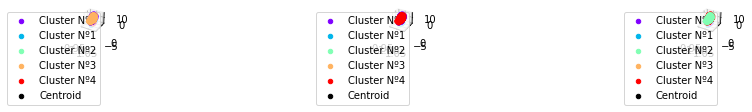

In [469]:
startKmean(maxk=16,treshold=1/11)

## K-means vs Z-Score

The output follows the format:

Considering a threshold of 1/k, where k is the number of k, we can observe that for most cases, a multitude of outliers is detected, albeit in groups, as these are the ones with less value. Regarding the results attained in exercise **3.4**, z-score seems to detect individual outliers in each group easier. This is die to the fact that it computes the test for each point. K-means, on the other hand, considers the group that has less points independently. This can be lead to a more performant outlier detection mechanism, as it outrules not only the mean values, but also their distribuition. In the instant where a low distribution on a k cluster is observed, we can ignore it, as it's a rare case.

Finally, we verified that in certain cases, the z-score detects outliers, whereas the k-means doesn't.

This way, we conclude it's best to use z-score for outlier detection within the scope of this project.

## Exercise 3.7.1
DBSCAN implementation

In [522]:
from sklearn.cluster import DBSCAN

def startDBSCAN(dev = 1):
    for i in  range(0,3):
        
        if dev >= 0:
            filtered_data = [user_data[x][user_data[x][:,0]==dev] for x in range(0,15)]
        else:
            return
        
        for act in range(0, 15):
            print("Atividade {}".format(act))
            clustering = DBSCAN(eps=50,min_samples=2).fit(filtered_data[act])
            labels =np.array(clustering.labels_)
            print(len(labels))
            print(len(labels[np.where(labels == -1)]))


In [525]:
startDBSCAN()

Atividade 0
53120
62
Atividade 1
53376
15
Atividade 2
53248
253
Atividade 3
53268
1367
Atividade 4
53120
1259
Atividade 5
52861
278
Atividade 6
53632
152
Atividade 7
52480
27
Atividade 8
52992
68
Atividade 9
52480
530
Atividade 10
51456
855
Atividade 11
52864
92
Atividade 12
53120
92
Atividade 13
52992
21
Atividade 14
53248
1310
Atividade 0
53120
62
Atividade 1
53376
15
Atividade 2
53248
253
Atividade 3
53268
1367
Atividade 4
53120
1259
Atividade 5
52861
278
Atividade 6
53632
152
Atividade 7
52480
27
Atividade 8
52992
68
Atividade 9
52480
530
Atividade 10
51456
855
Atividade 11
52864
92
Atividade 12
53120
92
Atividade 13
52992
21
Atividade 14
53248
1310
Atividade 0
53120
62
Atividade 1
53376
15
Atividade 2
53248
253
Atividade 3
53268
1367
Atividade 4
53120
1259
Atividade 5
52861
278
Atividade 6
53632
152
Atividade 7
52480
27
Atividade 8
52992
68
Atividade 9
52480
530
Atividade 10
51456
855
Atividade 11
52864
92
Atividade 12
53120
92
Atividade 13
52992
21
Atividade 14
53248
1310


## DBSCAN vs K-Means

Generally speaking, we observe that DBSCAN is a clustering algorithm that behaves differently. It seems to the best at detecting outliers, as they are unlabelled. The main advantage lies in the fact that it doesn't need a k value for the number of clusters. However, it's necessary to know the best eps, distances and minimum number of clusters.

## Exercise 3.8

Outlier Injection method

In [526]:
def outliersInject(array,k, x) -> None:
    array = copy.deepcopy(array)
    nt = len(array)
    mean = np.mean(array)
    kdel = k * array.std()
    mask = (array > mean -kdel) & (array < mean+kdel)
    belongs = array[mask]
    n0 = len(array) - len(belongs)
    dens = density(n0,nt)
    q = np.amax(np.abs(array))  #z

    interval_q = np.linspace(0,q,1000) #intervalo de 0 a z para fora

    cond = x-dens
    print(dens)
    if cond > 0:

        size_c = int(len(belongs)*cond/100)+1

        random_index = np.random.choice(np.arange(len(belongs)),size=size_c, replace=False)

        for i in random_index:
            belongs[i] = mean + np.random.choice(np.array([-1,1]))*k*( array.std() + np.random.choice(interval_q))
        
        array[mask] = belongs
        mask = (array > mean -kdel) & (array < mean+kdel)
        belongs = array[mask]
        n0 = len(array) - len(belongs)
        print(density(n0,nt))
    else:
        print("It already has that many outliers.")
    return array
    


## Exercise 3.9

The code below determines the linear model of p-th order. It calculates the Theta that minimizes the error - distance from the actual point to the regression line.

$\beta = (X^TX)^{-1} X^TY$

In [527]:
def padding(arr):
    ''' padding - pad array with a column of ones
    
    1 2 3           1 1 2 3
    4 5 6   --->    1 4 5 6
    7 8 9           1 7 8 9

    '''

    #if len(arr.shape) == 1:
        #arr = arr.reshape(-1,1)

    return np.concatenate([np.ones((arr.shape[0],1)), arr],axis=1)

def linmod(X,y):
    '''linmod - calculate linear model of order p
    '''

    x = padding(X)
    
    return np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y.reshape(-1,1)).squeeze()

def predict(X, B):
    return padding(X).dot(B).squeeze()

## Exercise 3.10

In [528]:
# testing, only do for activity #2

data_act2 = data_mod[data_mod[:,5]==2][:50000]  # get data (with modules) for only activity 2 (testing purposes) and only 50000 samples
acc = data_act2[:,1]                            # get only the acceleration vector
acc_altered = outliersInject(acc,3,10)          # inject 10% of outliers

0.116
9.99


In [529]:
# max p
p_max = 15

# get clean data, outliers and index of outliers
clean, outliers, outliers_index = zscore(acc_altered,3)

# error
err = []
bs = []

# train model on clean data and find best p
for p in range(1,p_max):
    y = clean[p:]
    X = np.ones((len(clean)-p, p))
    for i in range(0,len(X)):
        X[i] = clean[i:p+i][::-1]

    b = linmod(X,y)

    pred = predict(X,b)

    err.append(np.mean(np.abs(y-pred)**2))
    bs.append(b)

best_p = np.argmin(err)+1
b = bs[np.argmin(err)]

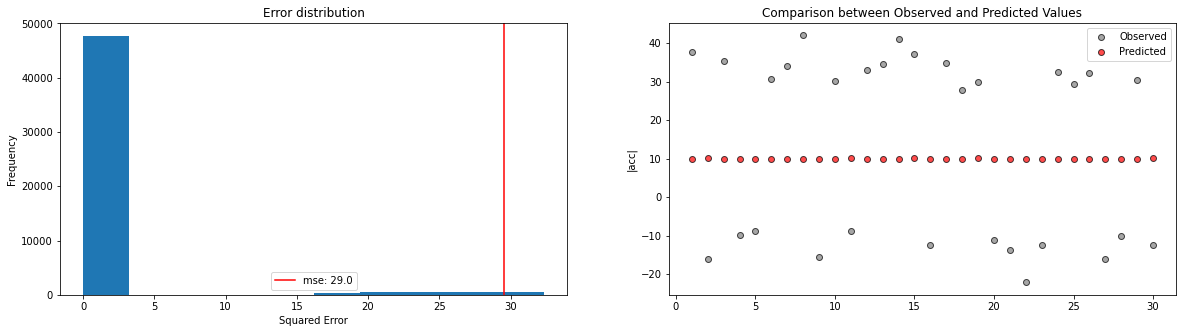

In [530]:
# copy array for replacing outliers
acc_corrected = acc_altered.copy()

for i in range(0, len(outliers_index)):
    if outliers_index[i] < best_p:
        continue

    y = acc_altered[outliers_index[i]]
    
    X = acc_altered[outliers_index[i]-best_p:outliers_index[i]][::-1].reshape(1,-1)

    pred = predict(X,b)

    acc_corrected[outliers_index[i]] = pred
    
err = np.abs(acc_altered - acc_corrected)

# build plots
n = 30 # sample size

fig, (plt_err_dist, plt_rp) = plt.subplots(1,2, figsize=(20,5))

# pot error distribution
plt_err_dist.set_title('Error distribution')
plt_err_dist.set_xlabel('Squared Error')
plt_err_dist.set_ylabel('Frequency')
plt_err_dist.hist(err)
plt_err_dist.axvline(np.mean(err**2), c='r', label=f'mse: {np.floor(np.mean(err**2))}')
plt_err_dist.legend()

# plot real vs predicted values
plt_rp.set_title('Comparison between Observed and Predicted Values')
plt_rp.set_ylabel('|acc|')
plt_rp.scatter(np.linspace(1,n,n), acc_altered[outliers_index][:n], alpha=0.7, color='grey', edgecolor='k', label='Observed')
plt_rp.scatter(np.linspace(1,n,n), acc_corrected[outliers_index][:n], alpha=0.7, color='red', edgecolors='k', label='Predicted')
    
plt_rp.legend()

The graph on the left shows that the model predicts fairly well for non outliers, as there is a very high frequency of small error margins (bar on the left). However, the squared error is suddenly a bit frequent on the 15-30 spectrum. This is an indication of the error achieved when replacing outliers with predicted values. As the model is trained on data without outliers, it fits a well defined lined. When predicting for values that are (sometimes) largely bigger (or smaller), the difference can be quite high. This is further proved by the image on the right. The image represents between outliers (colored gray) and values predicted by the linear model (colored red) for the acceleration model. In fact, the error is very large, going up to as much as 30, and achieving a mean squared error of 29. This can be due to very high values when inject outliers

# Exercise 4

## Exercise 4.1

In [531]:
from scipy.stats import norm, kstest

### Normality Test

In [532]:
activities = [0]*3
for i in range(3):
    plt_data = [0] * 16
    for j in range(0, 16): # each activity
        plt_data[j] = np.concatenate([data_transformed[x][data_transformed[x][:,5]==j+1][:,i+1] for x in range(0,15)])
    activities[i]=plt_data

In [533]:
def normal_test(plt_data):
    for i in range(0,16):
        print("Activitie {}".format(i))
        loc, scale = norm.fit(plt_data[i])
        # create a normal distribution with loc and scale
        n = norm(loc=loc, scale=scale)
        x1 = np.arange(np.array(plt_data[i]).min(), np.array(plt_data[i]).max(),0.05)
        plt.hist(plt_data[i], bins= x1, density=True)
        x = np.arange(np.array(plt_data[i]).min(), np.array(plt_data[i]).max()+0.2, 0.2)
        plt.plot(x,n.pdf(x))
        plt.show()
        print(kstest(plt_data[i],n.cdf))

Activitie 0


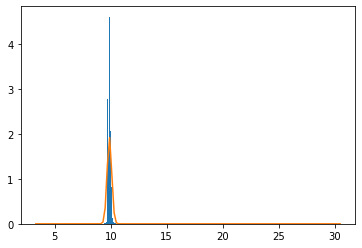

KstestResult(statistic=0.1617660451373944, pvalue=0.0)
Activitie 1


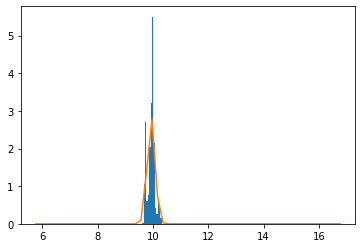

KstestResult(statistic=0.10540706154056811, pvalue=0.0)
Activitie 2


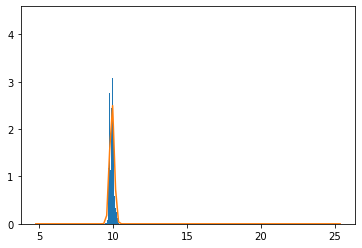

KstestResult(statistic=0.09123740666545377, pvalue=0.0)
Activitie 3


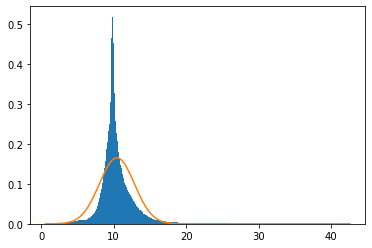

KstestResult(statistic=0.13843600385128907, pvalue=0.0)
Activitie 4


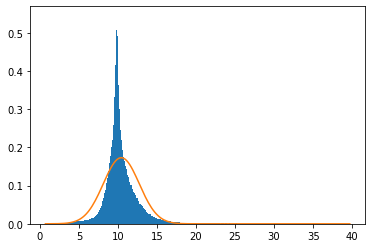

KstestResult(statistic=0.1351502527195536, pvalue=0.0)
Activitie 5


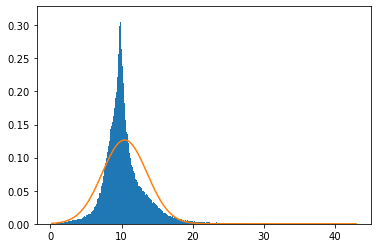

KstestResult(statistic=0.1341477998059627, pvalue=0.0)
Activitie 6


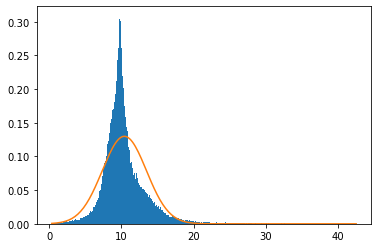

KstestResult(statistic=0.13221843757945728, pvalue=0.0)
Activitie 7


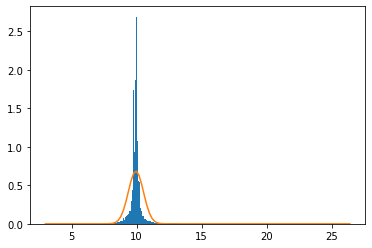

KstestResult(statistic=0.20913254519483349, pvalue=0.0)
Activitie 8


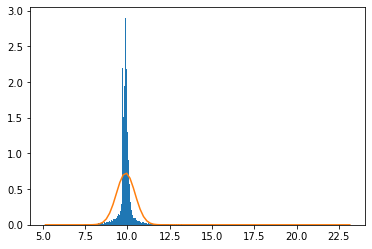

KstestResult(statistic=0.22746030015168944, pvalue=0.0)
Activitie 9


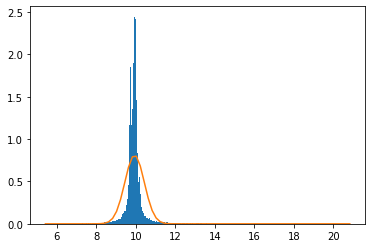

KstestResult(statistic=0.19938151941656057, pvalue=0.0)
Activitie 10


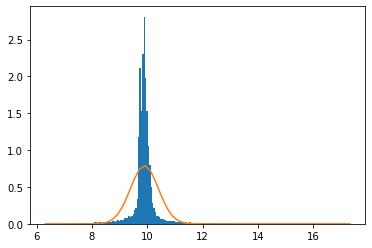

KstestResult(statistic=0.21790122581095733, pvalue=0.0)
Activitie 11


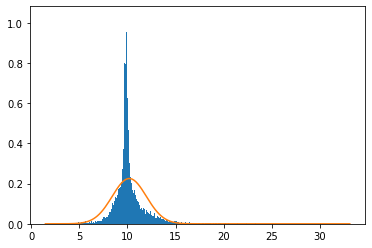

KstestResult(statistic=0.1691419555369672, pvalue=0.0)
Activitie 12


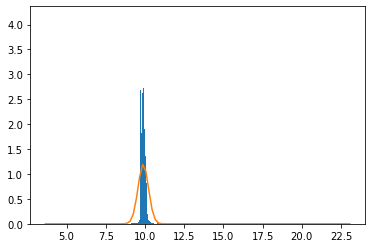

KstestResult(statistic=0.25153069052548094, pvalue=0.0)
Activitie 13


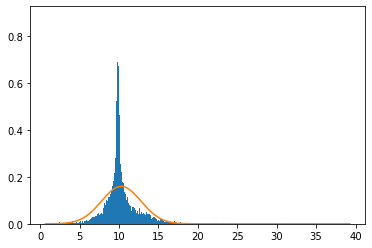

KstestResult(statistic=0.17286486409386348, pvalue=0.0)
Activitie 14


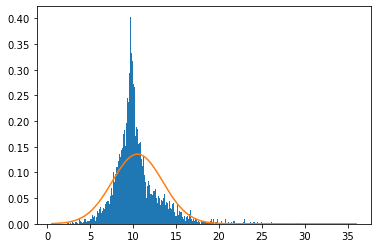

KstestResult(statistic=0.13448325340086575, pvalue=1.0694954051816471e-150)
Activitie 15


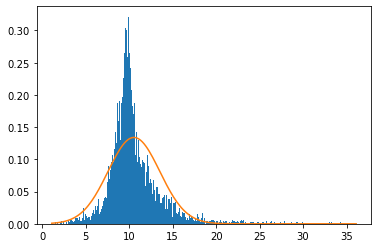

KstestResult(statistic=0.12724220576810696, pvalue=6.781576314660558e-135)


In [482]:
normal_test(activities[0])

Activitie 0


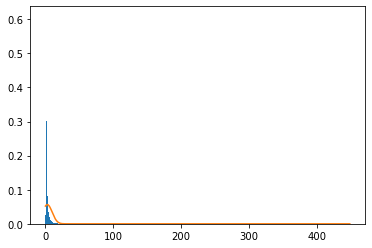

KstestResult(statistic=0.35094835212896436, pvalue=0.0)
Activitie 1


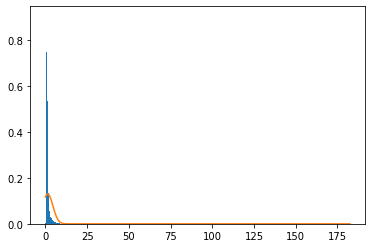

KstestResult(statistic=0.33942520722203373, pvalue=0.0)
Activitie 2


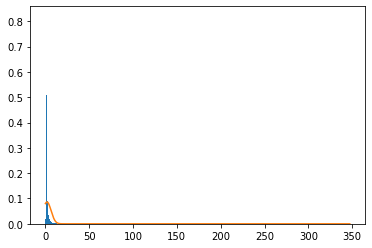

KstestResult(statistic=0.3581754058013694, pvalue=0.0)
Activitie 3


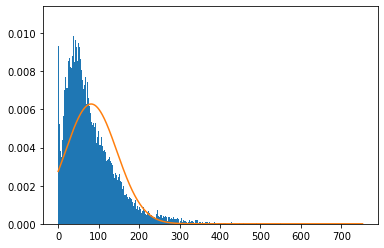

KstestResult(statistic=0.10963487977761371, pvalue=0.0)
Activitie 4


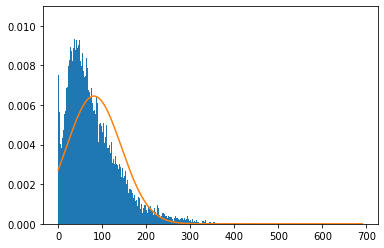

KstestResult(statistic=0.10573501308823835, pvalue=0.0)
Activitie 5


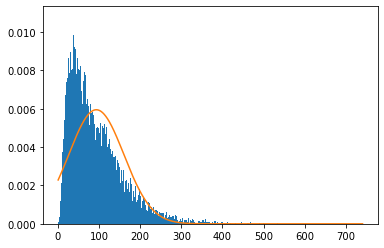

KstestResult(statistic=0.09629999567514046, pvalue=0.0)
Activitie 6


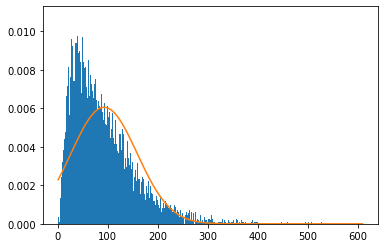

KstestResult(statistic=0.09379626819982247, pvalue=0.0)
Activitie 7


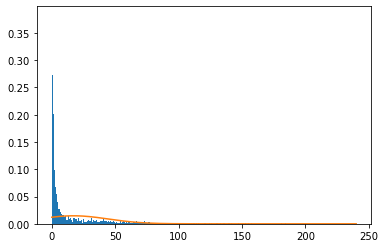

KstestResult(statistic=0.2649406527006409, pvalue=0.0)
Activitie 8


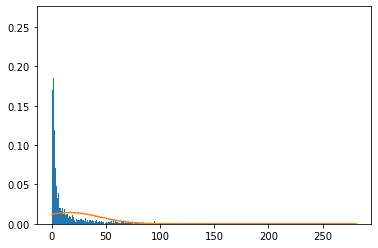

KstestResult(statistic=0.2777478983934764, pvalue=0.0)
Activitie 9


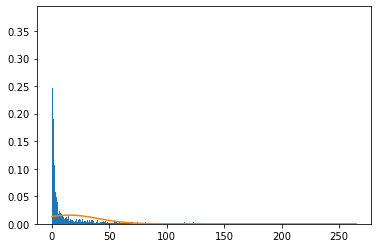

KstestResult(statistic=0.2749489872398455, pvalue=0.0)
Activitie 10


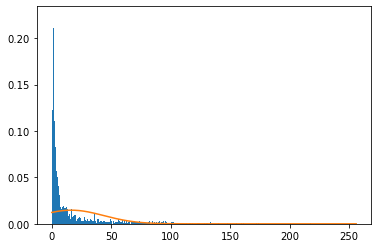

KstestResult(statistic=0.2741058233569437, pvalue=0.0)
Activitie 11


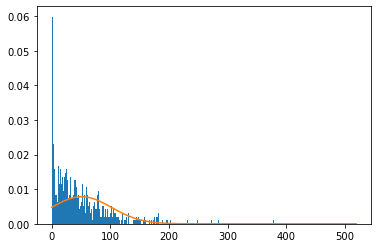

KstestResult(statistic=0.1594296389448962, pvalue=0.0)
Activitie 12


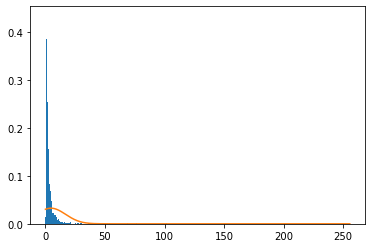

KstestResult(statistic=0.35455846586850903, pvalue=0.0)
Activitie 13


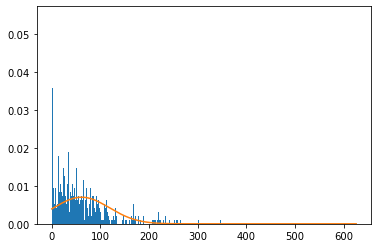

KstestResult(statistic=0.14131303741777732, pvalue=0.0)
Activitie 14


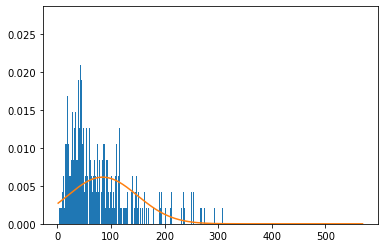

KstestResult(statistic=0.125848065077646, pvalue=5.914274100478343e-132)
Activitie 15


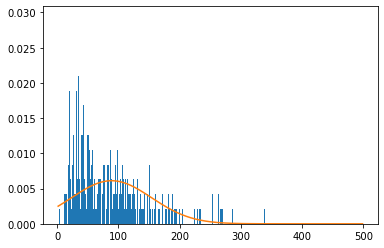

KstestResult(statistic=0.11951485151287172, pvalue=5.209017949890237e-119)


In [483]:
normal_test(activities[1])

Activitie 0


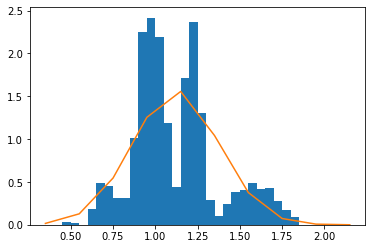

KstestResult(statistic=0.09349670116152753, pvalue=0.0)
Activitie 1


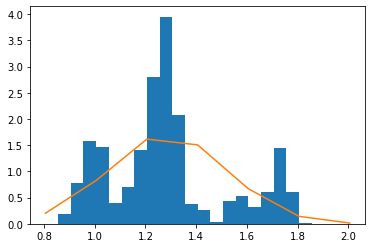

KstestResult(statistic=0.16123943618253456, pvalue=0.0)
Activitie 2


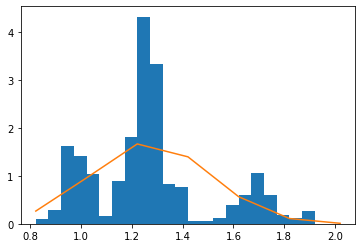

KstestResult(statistic=0.165982023230262, pvalue=0.0)
Activitie 3


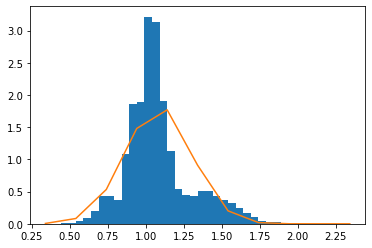

KstestResult(statistic=0.1302781510239136, pvalue=0.0)
Activitie 4


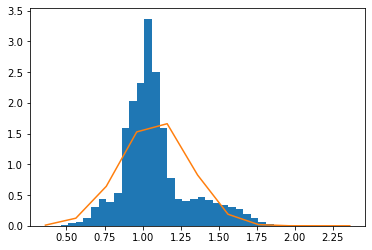

KstestResult(statistic=0.13721719160463797, pvalue=0.0)
Activitie 5


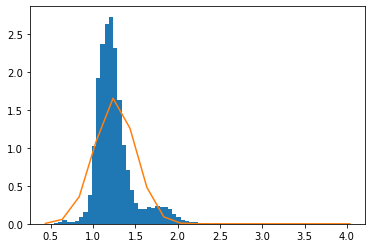

KstestResult(statistic=0.14663456072282421, pvalue=0.0)
Activitie 6


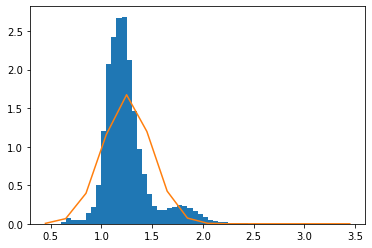

KstestResult(statistic=0.14093425526081504, pvalue=0.0)
Activitie 7


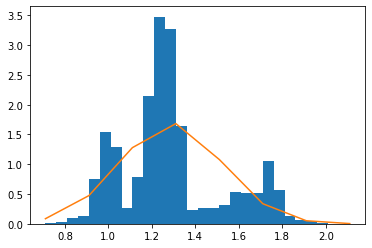

KstestResult(statistic=0.16283205602913586, pvalue=0.0)
Activitie 8


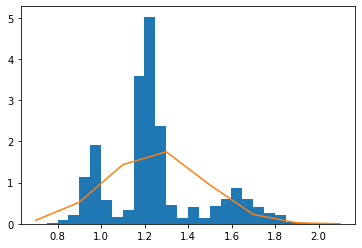

KstestResult(statistic=0.19129956127868808, pvalue=0.0)
Activitie 9


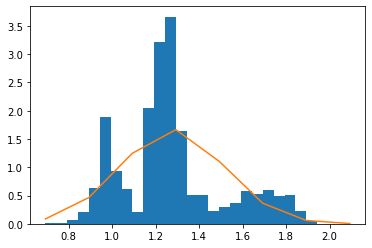

KstestResult(statistic=0.16644008093016927, pvalue=0.0)
Activitie 10


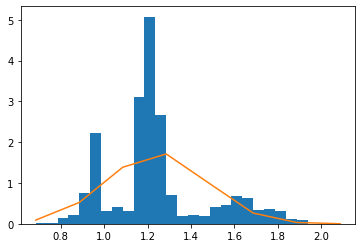

KstestResult(statistic=0.18850329345526695, pvalue=0.0)
Activitie 11


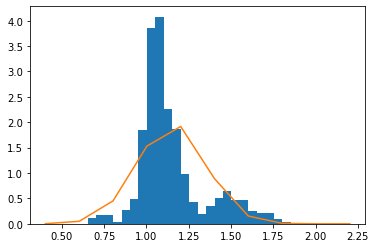

KstestResult(statistic=0.15563280661734763, pvalue=0.0)
Activitie 12


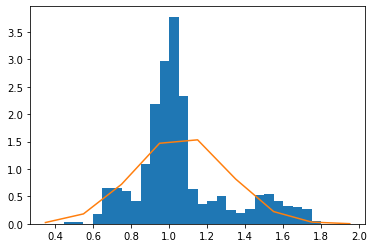

KstestResult(statistic=0.18956036976922608, pvalue=0.0)
Activitie 13


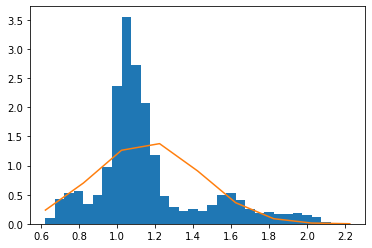

KstestResult(statistic=0.1880328866528812, pvalue=0.0)
Activitie 14


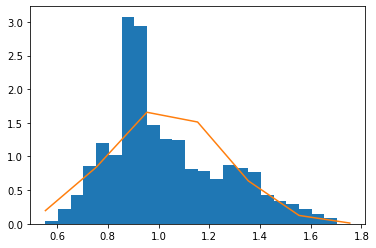

KstestResult(statistic=0.12291029380843127, pvalue=7.257959388870688e-126)
Activitie 15


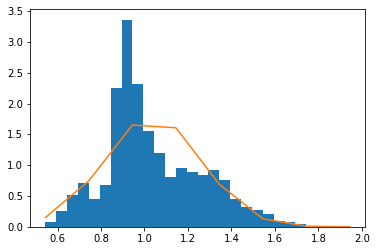

KstestResult(statistic=0.10876343950368528, pvalue=1.3925367184835603e-98)


In [484]:
normal_test(activities[2])

## Friedman Test

Friedman test is performed as this cumplies with requirements demand by the dataset. Data is not normalized, and has multiple features and x, y and z variants.
É feito o friedman pois este cumpre os requisitos do dataset. O data não é normal, e tem múltiplas features, x,y,z.

In [485]:
from scipy.stats import friedmanchisquare

def fried_test(activities):
    for i in range(0,16):
        print("Activity {}:".format(i))
        print(friedmanchisquare(activities[0][i],activities[1][i],activities[2][i]))

In [ ]:
fried_test(activities)

As p-value is less than 0.05, we can say that all 3 of them are not interconnected

## Exercise 4.2

Below are the methods used for extracting the features mentioned.

In [535]:
def SMA(x,y,z):
    size = len(x)
    return np.sum(np.absolute(x))+np.sum(np.absolute(y))+np.sum(np.absolute(z))

In [536]:
def features_single(x, window_index):
    median_X = [np.median(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)]) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    std_X = [x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)].std() for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    var_X = [np.var(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)]) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    root_mean_sqrd_X = [np.sqrt(np.mean(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)]**2)) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    avg_derivative_X = [np.mean(np.gradient(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)])) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    skew_X = [stats.skew(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)]) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    kurtosis_X = [stats.kurtosis(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)]) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    q75 = [np.percentile(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)], [75 ]) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    q25 = [np.percentile(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)], [25 ]) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    iqr_X = np.array(q75) - np.array(q25) 
    return median_X, std_X,var_X, root_mean_sqrd_X, avg_derivative_X, skew_X, kurtosis_X, iqr_X

In [537]:
def energy(x,windows_index):
    return [np.sum(fft(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)])**2)/len(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)]) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]

def averageEnergy(x,y,z,fs):
    ener_X = energy(x,fs)
    ener_Y = energy(y,fs)
    ener_Z = energy(z,fs)
    final = [ener_X,ener_Y,ener_Z]
    return np.mean(final,axis=0)

In [538]:
def dominant_frequencies(x):
    value = np.argmax(fft(x)**2)
    return value

def avh(y,z,windows_index,fs):
    #Vezes 3 porque é o intervalo de tempo e a = v/(intervalo de tempo) <=> a x intervalo de tempo  e no nosso caso é 3 segundos(2 + 50%)
    avg_y = [np.mean(y[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)] * 3) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    avg_z = [np.mean(z[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)] * 3) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    return [spatial.distance.euclidean(avg_y[i],avg_z[i]) for i in range(len(avg_y))]

def norm_euc(x,y):
    return np.array([[ np.linalg.norm(i-j) for j in y] for i in x])

def corrAccGr(x,y,z):
    euc_norm = norm_euc(y,z)
    return np.corrcoef(euc_norm,x)

In [539]:
import scipy.integrate as integrate

def averageRotation(x,y,windows_index):
    angles= [np.mean(np.arctan2( x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)], y[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)])) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    return angles

def VelocityGravity(x):
    value = [np.trapz(x[i:i+2]) for i in range(len(x)-1)]
    return value

def AvgVelGravity(x,windows_index):
    avg = [ np.mean(VelocityGravity(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)])) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    return avg

In [540]:
from scipy.signal import periodogram

def zero_crosses(x, windows_index):
    zero_crosses_X = [np.nonzero(np.diff(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)]>0))[0].size for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    return zero_crosses_X

def mean_crosses(x, windows_index):
    mean_X = np.mean(x)
    mean_crosses_X = [np.nonzero(np.diff(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)]>mean_X))[0].size for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    return mean_crosses_X

def stdWindow(x,windows_index):
    return [np.array(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)]).std() for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]

def meanWindow(x,windows_index):
    mean_X = [np.mean(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)]) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    return mean_X

def corrCoef(x,y, windows_index):
    corr_X_Y = [np.corrcoef(x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)],y[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)]) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    return corr_X_Y

def eigen(x,y,z,windows_index):
    #Eigenvalue
    x_w = [np.cov(np.stack((x[windows_index[i]: windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)],y[windows_index[i]: windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)],z[windows_index[i]: windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)]))) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]
    
    w = [np.max(np.linalg.eig(i)[0]) for i in x_w]
    
    return w

def spectar_window(x,windows_index):
    X = np.array(periodogram(x,fs=fs))
    X_norm = X/np.sum(X)
    return [stats.entropy(X_norm[windows_index[i]: windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)]) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]

In [541]:
def SMA_Window(x,y,z,windows_index):
    return [SMA( x[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)], y[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)], z[windows_index[i]:windows_index[i+1] + int(((windows_index[0]+windows_index[1]))/2)] ) for i in range(len(windows_index)-int(((windows_index[0]+windows_index[1]))/2))]

In [543]:
data_untransformed = [np.column_stack((
    user_data[x][:,0],
    user_data[x][:,1:4], # acceleration 
    user_data[x][:,4:7], # gyroscope module
    user_data[x][:,7:10], # magnetometer module
    user_data[x][:,10:]
)) for x in range(0,15)]

In [544]:
acc = data_untransformed[0][:,1:4]
gyr = data_untransformed[0][:,4:7]
mag = data_untransformed[0][:,7:10]

acc_mod = data_transformed[0][:,1]
gyr_mod = data_transformed[0][:,2]
mag_mod = data_transformed[0][:,3]

f_x = dominant_frequencies(acc[:,0])
f_y = dominant_frequencies(acc[:,1])
f_z = dominant_frequencies(acc[:,2])
fs = 2*np.max([f_x,f_y,f_z])

windows_index = np.arange(0,len(acc[:,0]),int(2*fs))

## Acceleration Features

In [ ]:
acc_sma = SMA_Window(acc[:,0],acc[:,1],acc[:,2],windows_index)

acc_corr_X_Y = corrCoef(acc[:,0],acc[:,1],windows_index)
acc_corr_Y_Z = corrCoef(acc[:,1],acc[:,2],windows_index)
acc_corr_X_Z = corrCoef(acc[:,0],acc[:,2],windows_index)

acc_mean_mod = meanWindow(acc_mod,windows_index)

acc_mean_X = meanWindow(acc[:,0],windows_index)
acc_mean_Y = meanWindow(acc[:,1],windows_index)
acc_mean_Z = meanWindow(acc[:,2],windows_index)

acc_std_mod = stdWindow(acc_mod,windows_index)

acc_std_X = stdWindow(acc[:,0],windows_index)
acc_std_X = stdWindow(acc[:,1],windows_index)
acc_std_X = stdWindow(acc[:,2],windows_index)

acc_spectar_x = spectar_window(acc[:,0],windows_index)
acc_spectar_y = spectar_window(acc[:,1],windows_index)
acc_spectar_z = spectar_window(acc[:,2],windows_index)

acc_eig_y = eigen(acc[:,1],windows_index)
acc_eig_x = eigen(acc[:,0],windows_index)
acc_eig_z = eigen(acc[:,2],windows_index)

acc_median_X, acc_std_X,acc_var_X, acc_root_mean_sqrd_X, acc_avg_derivative_X, acc_skew_X, acc_kurtosis_X, acc_iqr_X = features_single(acc[:,0],windows_index)
acc_median_Y, acc_std_Y,acc_var_Y, acc_root_mean_sqrd_Y, acc_avg_derivative_Y, acc_skew_Y, acc_kurtosis_Y, acc_iqr_Y = features_single(acc[:,1],windows_index)
acc_median_Z, acc_std_Z,acc_var_Z, acc_root_mean_sqrd_Z, acc_avg_derivative_Z, acc_skew_Z, acc_kurtosis_Z, acc_iqr_Z = features_single(acc[:,2],windows_index)

acc_mean_crosses_X = mean_crosses(acc[:,0],windows_index)
acc_mean_crosses_Y = mean_crosses(acc[:,1],windows_index)
acc_mean_crosses_Z = mean_crosses(acc[:,2],windows_index)
acc_zero_crosses_X = zero_crosses(acc[:,0],windows_index)
acc_zero_crosses_Y = zero_crosses(acc[:,1],windows_index)
acc_zero_crosses_Z = zero_crosses(acc[:,2],windows_index)

acc_avgGravity_X = AvgVelGravity(acc[:,0],windows_index) #assumindo que x é a gravidade
acc_averageRotation_Y = averageRotation(acc[:,0],acc[:,1],windows_index)
acc_averageRotation_Z = averageRotation(acc[:,0],acc[:,2],windows_index)

acc_ener_X =energy(acc[:,0],windows_index)
acc_ener_Y = energy(acc[:,1],windows_index)
acc_ener_Z = energy(acc[:,2],windows_index)

avg_acc_energy = averageEnergy(acc[:,0],acc[:,1],acc[:,2],windows_index)

## Gyroscope features

In [ ]:
gyr_sma = SMA_Window(gyr[:,0],gyr[:,1],gyr[:,2],windows_index)

gyr_corr_X_Y = corrCoef(gyr[:,0],gyr[:,1],windows_index)
gyr_corr_Y_Z = corrCoef(gyr[:,1],gyr[:,2],windows_index)
gyr_corr_X_Z = corrCoef(gyr[:,0],gyr[:,2],windows_index)

gyr_mean_mod = meanWindow(gyr_mod,windows_index)

gyr_mean_X = meanWindow(gyr[:,0],windows_index)
gyr_mean_Y = meanWindow(gyr[:,1],windows_index)
gyr_mean_Z = meanWindow(gyr[:,2],windows_index)

gyr_std_mod = stdWindow(gyr_mod,windows_index)

gyr_std_X = stdWindow(gyr[:,0],windows_index)
gyr_std_X = stdWindow(gyr[:,1],windows_index)
gyr_std_X = stdWindow(gyr[:,2],windows_index)

gyr_spectar_x = spectar_window(gyr[:,0],windows_index)
gyr_spectar_y = spectar_window(gyr[:,1],windows_index)
gyr_spectar_z = spectar_window(gyr[:,2],windows_index)

gyr_eig_y = eigen(gyr[:,1],windows_index)
gyr_eig_x = eigen(gyr[:,0],windows_index)
gyr_eig_z = eigen(gyr[:,2],windows_index)

gyr_median_X, gyr_std_X,gyr_var_X, gyr_root_mean_sqrd_X, gyr_avg_derivative_X, gyr_skew_X, gyr_kurtosis_X, gyr_iqr_X = features_single(gyr[:,0],windows_index)
gyr_median_Y, gyr_std_Y,gyr_var_Y, gyr_root_mean_sqrd_Y, gyr_avg_derivative_Y, gyr_skew_Y, gyr_kurtosis_Y, gyr_iqr_Y = features_single(gyr[:,1],windows_index)
gyr_median_Z, gyr_std_Z,gyr_var_Z, gyr_root_mean_sqrd_Z, gyr_avg_derivative_Z, gyr_skew_Z, gyr_kurtosis_Z, gyr_iqr_Z = features_single(gyr[:,2],windows_index)

gyr_mean_crosses_X = mean_crosses(gyr[:,0],windows_index)
gyr_mean_crosses_Y = mean_crosses(gyr[:,1],windows_index)
gyr_mean_crosses_Z = mean_crosses(gyr[:,2],windows_index)
gyr_zero_crosses_X = zero_crosses(gyr[:,0],windows_index)
gyr_zero_crosses_Y = zero_crosses(gyr[:,1],windows_index)
gyr_zero_crosses_Z = zero_crosses(gyr[:,2],windows_index)

gyr_avgGravity_X = AvgVelGravity(gyr[:,0],windows_index) #assumindo que x é a gravidade
gyr_averageRotation_Y = averageRotation(gyr[:,0],gyr[:,1],windows_index)
gyr_averageRotation_Z = averageRotation(gyr[:,0],gyr[:,2],windows_index)

gyr_ener_X =energy(gyr[:,0],windows_index)
gyr_ener_Y = energy(gyr[:,1],windows_index)
gyr_ener_Z = energy(gyr[:,2],windows_index)

avg_gyro_energy = averageEnergy(gyr[:,0],gyr[:,1],gyr[:,2],windows_index)

## Magnetometer Features

In [ ]:
mag_sma = SMA_Window(mag[:,0],mag[:,1],mag[:,2],windows_index)

mag_corr_X_Y = corrCoef(mag[:,0],mag[:,1],windows_index)
mag_corr_Y_Z = corrCoef(mag[:,1],mag[:,2],windows_index)
mag_corr_X_Z = corrCoef(mag[:,0],mag[:,2],windows_index)

mag_mean_mod = meanWindow(mag_mod,windows_index)

mag_mean_X = meanWindow(mag[:,0],windows_index)
mag_mean_Y = meanWindow(mag[:,1],windows_index)
mag_mean_Z = meanWindow(mag[:,2],windows_index)

mag_std_mod = stdWindow(mag_mod,windows_index)

mag_std_X = stdWindow(mag[:,0],windows_index)
mag_std_X = stdWindow(mag[:,1],windows_index)
mag_std_X = stdWindow(mag[:,2],windows_index)

mag_spectar_x = spectar_window(mag[:,0],windows_index)
mag_spectar_y = spectar_window(mag[:,1],windows_index)
mag_spectar_z = spectar_window(mag[:,2],windows_index)

mag_eig_y = eigen(mag[:,1],windows_index)
mag_eig_x = eigen(mag[:,0],windows_index)
mag_eig_z = eigen(mag[:,2],windows_index)

mag_median_X, mag_std_X,mag_var_X, mag_root_mean_sqrd_X, mag_avg_derivative_X, mag_skew_X, mag_kurtosis_X, mag_iqr_X = features_single(mag[:,0],windows_index)
mag_median_Y, mag_std_Y,mag_var_Y, mag_root_mean_sqrd_Y, mag_avg_derivative_Y, mag_skew_Y, mag_kurtosis_Y, mag_iqr_Y = features_single(mag[:,1],windows_index)
mag_median_Z, mag_std_Z,mag_var_Z, mag_root_mean_sqrd_Z, mag_avg_derivative_Z, mag_skew_Z, mag_kurtosis_Z, mag_iqr_Z = features_single(mag[:,2],windows_index)

mag_mean_crosses_X = mean_crosses(mag[:,0],windows_index)
mag_mean_crosses_Y = mean_crosses(mag[:,1],windows_index)
mag_mean_crosses_Z = mean_crosses(mag[:,2],windows_index)
mag_zero_crosses_X = zero_crosses(mag[:,0],windows_index)
mag_zero_crosses_Y = zero_crosses(mag[:,1],windows_index)
mag_zero_crosses_Z = zero_crosses(mag[:,2],windows_index)

mag_avgGravity_X = AvgVelGravity(mag[:,0],windows_index) #assumindo que x é a gravidade
mag_averageRotation_Y = averageRotation(mag[:,0],mag[:,1],windows_index)
mag_averageRotation_Z = averageRotation(mag[:,0],mag[:,2],windows_index)

mag_ener_X =energy(mag[:,0],windows_index)
mag_ener_Y = energy(mag[:,1],windows_index)
mag_ener_Z = energy(mag[:,2],windows_index)

## Exercise 4.3

sk-learn's PCA implementation was used for this exercise

In [546]:
# sklearn implementation

from sklearn.decomposition import PCA

## Exercise 4.4
In order to achieve *at least* 75% explainability on the feature set, the number of dimensions to use is `n=6`, to which we achieve a variance explainability of 78%

In [547]:
# normalize dataset

data= all_data.copy()
X = data[:,:11]
y = data[:,11]

for i in range(0, X.shape[1]):
    X[:,i] = (X[:,i] - X[:,i].mean()) / X[:,i].std() # zscore

[26. 12. 11. 10.  8.  8.]
Explained Variance: 78.0 %


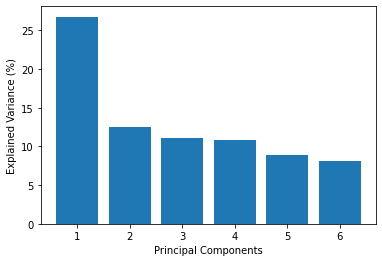

In [548]:
# calculate principal components

dim = 6
pca = PCA(dim)
pca_x = pca.fit_transform(X)
print(np.floor(pca.explained_variance_ratio_*100))
print(f'Explained Variance: {np.floor(np.sum(pca.explained_variance_ratio_)*100)} %')

plt.xlabel('Principal Components')
plt.xticks(np.linspace(1, dim, dim))
plt.ylabel('Explained Variance (%)')
plt.bar(np.linspace(1,dim,dim),pca.explained_variance_ratio_*100,)
plt.show()

From the image below, we can see the distribution of explained variance per principal components, and conclude that their sum equals a total of 78% explainability.

### Exercise 4.4.1

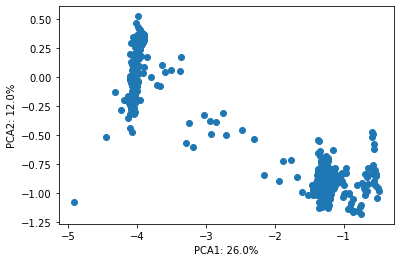

In [549]:
plt.xlabel(f'PCA1: {np.floor(pca.explained_variance_ratio_[0]*100)}%')
plt.ylabel(f'PCA2: {np.floor(pca.explained_variance_ratio_[1]*100)}%')
plt.scatter(pca_x[:4000,0], pca_x[:4000,1])
plt.show()

Here we can se a somewhat clear division between the principal components 1 and 2, the ones that explain the variance the most. We can also understand that data variates more along the PCA1 axis.

### Exercise 4.4.2
Using Principal Component Analysis (PCA) for dimensionality reduction has the advantage of reducing the feature space of a dataset, while still maintining a reasonable explainability. As such, it's able to improve the performance of ML algorithms, by discarding correlated features that have mininum impact on the overall decision process. PCA is also helpful for data visualisation as it produces a new feature space with lower dimensionality and maximal variability.
On the other hand, some information will inescapably be lost, which further aggravates when reducing into lower dimensions. Additionaly, as a new feature space is produced, the new features -- the principal components -- are not interpretable and have no real-life meaning, as opposed to the original features.